In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from ngram import *
from baselines import *
from error_analysis import *

### Load Annotated Data

In [2]:
data_filename  = '../../data/v4_annotated/annotated_onion_layer_5_rows_0_to_5000_raters_20.csv'
d_b = load_cf_labels(data_filename)
d_b = tidy_labels(d_b)

data_filename  = '../../data/v4_annotated/annotated_random_data_rows_0_to_5000_raters_20.csv'
d_r = load_cf_labels(data_filename)
d_r = tidy_labels(d_r)

In [3]:
l_b = plurality(d_b['recipient'].dropna())
l_r = plurality(d_r['recipient'].dropna())

In [4]:
data_b = get_labeled_comments(d_b, l_b)
data_r = get_labeled_comments(d_r, l_r)

### NGram Classification Pipeline

In [5]:
cv_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LinearSVC()),
])

In [6]:
param_grid = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None,), #(None, 5000, 10000, 50000),
    'vect__ngram_range': ((1,6),(1,5)),  # unigrams or bigrams
    #'vect_lowercase': (True, False),
    'vect__analyzer' : ('char',), #('word', 'char')
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__C': (0.001, 0.1, 1.0, 5.0, 10)
}

In [7]:
train, test = split(data_b)
model = tune (train['x'], train['y'], cv_pipeline, param_grid, 'roc_auc', n_jobs=8, verbose=True)
evaluate(model, test, roc_auc, plot = False)


Best parameters set found:
{'vect__max_features': None, 'vect__ngram_range': (1, 5), 'clf__C': 0.1, 'vect__analyzer': 'char'} 0.914423094585


Grid scores:
0.72512 (+/-0.00000) for {'vect__max_features': None, 'vect__ngram_range': (1, 6), 'clf__C': 0.001, 'vect__analyzer': 'char'}
0.71680 (+/-0.00000) for {'vect__max_features': None, 'vect__ngram_range': (1, 5), 'clf__C': 0.001, 'vect__analyzer': 'char'}
0.91438 (+/-0.00000) for {'vect__max_features': None, 'vect__ngram_range': (1, 6), 'clf__C': 0.1, 'vect__analyzer': 'char'}
0.91442 (+/-0.00000) for {'vect__max_features': None, 'vect__ngram_range': (1, 5), 'clf__C': 0.1, 'vect__analyzer': 'char'}
0.91016 (+/-0.00000) for {'vect__max_features': None, 'vect__ngram_range': (1, 6), 'clf__C': 1.0, 'vect__analyzer': 'char'}
0.90908 (+/-0.00000) for {'vect__max_features': None, 'vect__ngram_range': (1, 5), 'clf__C': 1.0, 'vect__analyzer': 'char'}


0.90269773657395802

In [8]:
optimal_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,6))),
    ('tfidf', TfidfTransformer(sublinear_tf=True, norm='l2')),
    ('clf', LinearSVC(C = 1.0)),
])

### Error Analysis

In [9]:
fn, fp = get_clf_errors(model, test)

In [10]:
# extreme False negatives
print_clf_errors(fn)

COMMENT:
maroo doingaroo itaroo becausearoo Iaroo sawaroo somearoo evolutionsaroo inaroo thataroo programaroo andaroo heardaroo thearoo onesaroo thataroo werearoo mentionedaroo, somebodyaroo addedaroo somearoo accordingaroo thingaroo onaroo itaroo whicharoo didaroo notaroo happenaroo inaroo thearoo showaroo
SCORES: Actual: 1, Predicted: 0, Score: -0.82


COMMENT:
Nope, sorry scumbag. I'm just a random guy reading about the petty (though not really disturbing) underbelly of Wikipedia. And it's pretty amusing that the guy who got blocked was 'right' all along, given the current content of your precious Rock Lobster article. Also, if I was vanboto, wouldn't an indefinite block have kept me blocked?
SCORES: Actual: 1, Predicted: 0, Score: -0.75


COMMENT:
cradle of filthAre you unable to understand the text written in large capital letters next to the genre? Do not add Symponic Metal again, it will be removed.   
SCORES: Actual: 1, Predicted: 0, Score: -0.70


COMMENT:
 Don't touch my page

In [11]:
# extreme False positives
print_clf_errors(fp)

COMMENT:
up, HES A FRAUD, A FUCKING FRAUD!!!!!!
SCORES: Actual: 0, Predicted: 1, Score: 0.27


COMMENT:
 jp gordon is a fucking kike
SCORES: Actual: 0, Predicted: 1, Score: 0.20


COMMENT:
gay fucking faggot who has no life and no job and spends his whole shitty fucking life on wikipedia feeling powerful because he can ban and block peoples ips. hes a basement dwelling cunt. Not that i'm suprised however if I had a face like that I would stay indoors too.
SCORES: Actual: 0, Predicted: 1, Score: 0.11


COMMENT:
 So you want to block me I really don't care if you are going to block me or not. If you are going to block me, I request that you delete my user page.Thank you in advance.  
SCORES: Actual: 0, Predicted: 1, Score: 0.10




### Does adding random data improve prediction on blocked data?

Incrementally add random data to full blocked data set on training. Eval on held out blocked data.

In [12]:
ms, metrics = eval_adding_other_data(optimal_pipeline, data_b, data_r, roc_auc)

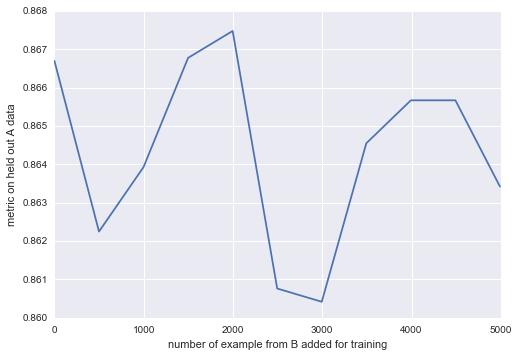

In [13]:
plot_adding_other_data(ms, metrics)

# Final Model

In [15]:
data = pd.concat([data_r,data_b])
model = optimal_pipeline.fit(data['x'], data['y'])
joblib.dump(model, '../../models/recipient_ngram.pkl')

['../../models/recipient_ngram.pkl',
 '../../models/recipient_ngram.pkl_01.npy',
 '../../models/recipient_ngram.pkl_02.npy',
 '../../models/recipient_ngram.pkl_03.npy',
 '../../models/recipient_ngram.pkl_04.npy',
 '../../models/recipient_ngram.pkl_05.npy']